In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import PVSystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [25]:
df = pd.read_csv("../Dataset/Nasa Datasets/kerman.csv")
kerman_loc=Location(longitude=57.0788,latitude=30.2830,tz="Iran")

In [5]:
# df=df[df["YEAR"]>=2024]

In [62]:
df = df.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'})
df["date"]=pd.to_datetime(df[["year","month","day"]])
df['date_iran'] = df['date'].dt.tz_localize('Asia/Tehran',nonexistent='shift_forward').apply(lambda ts: ts.replace(hour=12))

df

,year,month,day,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,T2M,RH2M,WS10M,CLOUD_AMT_DAY,week,P (W),date,date_iran
0,2010,1,1,1.68,3.72,0.80,1.28,0.31,2.46,88.80,5.07,89.74,1,18.724254,2010-01-01,2010-01-01 12:00:00+03:30
1,2010,1,2,3.30,3.92,5.31,0.98,0.60,2.77,68.33,4.09,39.80,1,65.102319,2010-01-02,2010-01-02 12:00:00+03:30
2,2010,1,3,4.05,4.15,8.03,0.58,0.74,5.07,42.25,4.39,7.37,1,86.568765,2010-01-03,2010-01-03 12:00:00+03:30
3,2010,1,4,3.09,4.16,1.90,2.14,0.56,6.64,38.67,4.40,89.04,1,59.091161,2010-01-04,2010-01-04 12:00:00+03:30
4,2010,1,5,4.07,4.16,7.91,0.65,0.74,6.49,35.11,3.08,9.41,1,87.141161,2010-01-05,2010-01-05 12:00:00+03:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,2024,12,28,3.66,3.77,5.02,1.27,0.68,6.75,30.86,4.37,18.45,4,75.406599,2024-12-28,2024-12-28 12:00:00+03:30
5476,2024,12,29,3.68,3.76,5.28,1.18,0.68,8.37,55.30,5.07,18.28,5,75.979038,2024-12-29,2024-12-29 12:00:00+03:30
5477,2024,12,30,2.42,3.63,0.47,1.96,0.45,6.82,78.78,4.37,96.77,5,39.911084,2024-12-30,2024-12-30 12:00:00+03:30
5478,2024,12,31,1.81,3.43,0.38,1.48,0.33,5.61,83.78,4.54,98.23,5,22.446483,2024-12-31,2024-12-31 12:00:00+03:30


In [63]:
selected_pannel="aSiMicro03036"
modual_infos=pd.read_csv("./simulation prams/module_params_custom_material.csv",index_col="Model")
temp_infos =pd.read_csv("./simulation prams/Temperature_Parameters_for_Each_PV_Model.csv",index_col="Model",usecols=["Model","a","b","deltaT"])
cec_inverter = pvlib.pvsystem.retrieve_sam(name="CECInverter") 

inverter_params =cec_inverter["ABB__PVI_3_0_OUTD_S_US__208V_"]
module_params = modual_infos.loc[selected_pannel]
temp_params=temp_infos.loc[selected_pannel]

# Old

In [8]:
inverter_params

Vac                          208
Pso                    18.166279
Paco                      3000.0
Pdco                  3142.30127
Vdco                       310.0
C0                     -0.000008
C1                     -0.000011
C2                      0.000999
C3                     -0.000287
Pnt                          0.1
Vdcmax                     480.0
Idcmax                 10.136456
Mppt_low                   100.0
Mppt_high                  480.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__PVI_3_0_OUTD_S_US__208V_, dtype: object

In [9]:
module_params

Vintage                  NaN
Area                    1.42
Material             Si-Film
Cells_in_Series          180
Parallel_Strings           1
Isco                0.806778
Voco                 230.438
Impo                 0.66841
Vmpo                 169.889
Aisc                0.001096
Aimp                0.000972
C0                  0.999782
C1                  0.000218
Bvoco               -0.77364
Mbvoc                      0
Bvmpo               -0.52344
Mbvmp                      0
N                     3.0465
C2                  0.114295
C3                  -2.82427
A0                  0.938534
A1                  0.125627
A2                 -0.070048
A3                  0.009405
A4                 -0.000412
B0                         1
B1                 -0.002966
B2                  0.000397
B3                 -0.000017
B4                       0.0
B5                      -0.0
DTC                        3
FD                         1
A                  -3.495404
B             

In [10]:
input_df=pd.DataFrame()
input_df['ghi_Wm2'] = df['ALLSKY_SFC_SW_DWN'] * 1000.0 
input_df['temp_air']   = df['T2M']
input_df['wind_speed'] = df['WS10M']
input_df["T2M"]=df["T2M"]

In [11]:
dc_power = pvlib.pvsystem.pvwatts_dc(
    effective_irradiance=input_df['ghi_Wm2'],
    temp_cell=input_df["T2M"],
    temp_ref=input_df['temp_air'],
    gamma_pdc = -0.0038,
    pdc0 = 169*0.66
)
ac_power = pvlib.inverter.pvwatts(
    pdc=dc_power,
    pdc0=inverter_params['Pdco'],
    eta_inv_nom=0.96
)
df['P (W)'] = ac_power
ac_power

5113    303.009203
5114    348.844407
5115    337.933308
5116    292.092736
5117    420.825614
           ...    
5475    381.570038
5476    383.751338
5477    246.229623
5478    179.578766
5479     95.377824
Length: 367, dtype: float64

In [18]:
df

,year,month,day,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT,T2M,RH2M,WS10M,CLOUD_AMT_DAY,week,P (W),date,date_iran
5113,2024,1,1,2.94,3.51,2.93,1.53,0.54,7.07,73.77,2.75,50.27,1,303.009203,2024-01-01,2024-01-01 00:00:00+03:30
5114,2024,1,2,3.36,3.75,4.44,1.35,0.61,6.47,62.69,1.52,27.49,1,348.844407,2024-01-02,2024-01-02 00:00:00+03:30
5115,2024,1,3,3.26,3.65,3.08,1.83,0.60,6.94,60.50,4.23,49.87,1,337.933308,2024-01-03,2024-01-03 00:00:00+03:30
5116,2024,1,4,2.84,3.76,2.80,1.66,0.52,5.64,62.77,3.53,62.47,1,292.092736,2024-01-04,2024-01-04 00:00:00+03:30
5117,2024,1,5,4.02,4.05,6.90,0.87,0.73,6.11,36.80,3.00,6.41,1,420.825614,2024-01-05,2024-01-05 00:00:00+03:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5475,2024,12,28,3.66,3.77,5.02,1.27,0.68,6.75,30.86,4.37,18.45,4,381.570038,2024-12-28,2024-12-28 00:00:00+03:30
5476,2024,12,29,3.68,3.76,5.28,1.18,0.68,8.37,55.30,5.07,18.28,5,383.751338,2024-12-29,2024-12-29 00:00:00+03:30
5477,2024,12,30,2.42,3.63,0.47,1.96,0.45,6.82,78.78,4.37,96.77,5,246.229623,2024-12-30,2024-12-30 00:00:00+03:30
5478,2024,12,31,1.81,3.43,0.38,1.48,0.33,5.61,83.78,4.54,98.23,5,179.578766,2024-12-31,2024-12-31 00:00:00+03:30


# Chain

In [64]:
input_df=df[["date_iran","ALLSKY_SFC_SW_DWN","ALLSKY_SFC_SW_DNI","ALLSKY_SFC_SW_DIFF","T2M","WS10M"]].copy()
input_df.set_index("date_iran",drop=True,inplace=True)

df_hourly = input_df.resample('h').ffill()
df_hourly=df_hourly.rename(columns={"ALLSKY_SFC_SW_DWN":"ghi",
                          "ALLSKY_SFC_SW_DNI":"dni",
                          "ALLSKY_SFC_SW_DIFF":"dhi",
                          "T2M":"temp_air",
                          "WS10M":"wind_speed"})
df_hourly["ghi"]=df_hourly["ghi"]* 1000.0/24 
df_hourly["dni"]=df_hourly["dni"]* 1000.0 /24
df_hourly["dhi"]=df_hourly["dhi"]* 1000.0 /24
df_hourly

,ghi,dni,dhi,temp_air,wind_speed
date_iran,,,,,
2010-01-01 12:00:00+03:30,70.000000,33.333333,53.333333,2.46,5.07
2010-01-01 13:00:00+03:30,70.000000,33.333333,53.333333,2.46,5.07
2010-01-01 14:00:00+03:30,70.000000,33.333333,53.333333,2.46,5.07
2010-01-01 15:00:00+03:30,70.000000,33.333333,53.333333,2.46,5.07
2010-01-01 16:00:00+03:30,70.000000,33.333333,53.333333,2.46,5.07
...,...,...,...,...,...
2025-01-01 08:00:00+03:30,75.416667,15.833333,61.666667,5.61,4.54
2025-01-01 09:00:00+03:30,75.416667,15.833333,61.666667,5.61,4.54
2025-01-01 10:00:00+03:30,75.416667,15.833333,61.666667,5.61,4.54


In [65]:
sandia_modules = pvlib.pvsystem.retrieve_sam(name="SandiaMod")
cec_inverter = pvlib.pvsystem.retrieve_sam(name="CECInverter") 
temp_params=TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"] 
module = sandia_modules["Canadian_Solar_CS5P_220M___2009_"]
inverter = cec_inverter["ABB__PVI_3_0_OUTD_S_US__208V_"]

system = PVSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_parameters=module_params,
    inverter_parameters=inverter_params,
    temperature_model_parameters=temp_params,
    # modules_per_string=1, # increase the number of moduals in EACH string  so total number of moduals = modules_per_string * strings_per_inverter
    # strings_per_inverter=1 #increase the number of stings connected to one inverter . this means the number of prallel strings 
    
)
model_chain = ModelChain(system,kerman_loc)

In [66]:
model_chain.run_model(df_hourly)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

<Axes: xlabel='date_iran'>

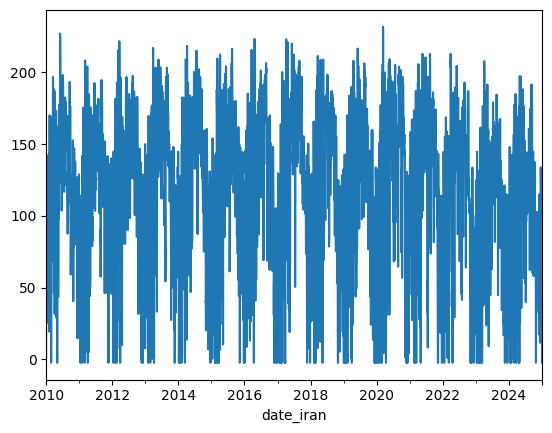

In [67]:
model_chain.results.ac.resample("D").sum().plot()

231.80886549534887

In [74]:
res_max=model_chain.results.ac.resample('D').max()
res_mean=model_chain.results.ac.resample('D').mean()

In [75]:
res_max.max()

99.78087521660119

In [77]:
res_mean

date_iran
2010-01-01 00:00:00+03:30    15.393257
2010-01-02 00:00:00+03:30    22.406550
2010-01-03 00:00:00+03:30    22.750819
2010-01-04 00:00:00+03:30    23.037916
2010-01-05 00:00:00+03:30    24.391194
                               ...    
2024-12-28 00:00:00+03:30    21.797238
2024-12-29 00:00:00+03:30    18.389462
2024-12-30 00:00:00+03:30    12.784093
2024-12-31 00:00:00+03:30     7.696455
2025-01-01 00:00:00+03:30     4.337886
Freq: D, Length: 5480, dtype: float64